**Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом**

**Задача:**
- 1. Сравните результат между тестом и контролем по двум кейсам:

Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value.
Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.


- 2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

❗️ Не сравнивайте p-value разных критериев в реальной жизни

1) Это повышает вероятность допустить ошибку I рода и вводит в заблуждение при анализе результатов применения критериев. 

2) Заранее формулируйте гипотезу и подбирайте под нее релевантный статистический критерий в рамках дизайна эксперимента

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('hw_bootstrap.csv', sep = ';')

In [3]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [4]:
df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [5]:
# Подготовим данные для дальнейшей передачи в бустрап функцию, заменим запятую на точку и приведем к формату float
df['value'] = df['value'].str.replace(',', '.')

In [6]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,10.3804953740268,Control
1,2,9.54686666784264,Control
2,3,11.0882146509904,Control
3,4,10.1472740570122,Control
4,5,9.78980767524929,Control


In [7]:
df.value = df.value.astype('float64')

In [8]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

Создадим вектора

In [9]:
df_control = df\
    .query('experimentVariant == "Control"')

In [10]:
df_control.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [11]:
df_treatment = df\
    .query('experimentVariant == "Treatment"')

In [12]:
df_treatment.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

**Бутстрап для среднего**

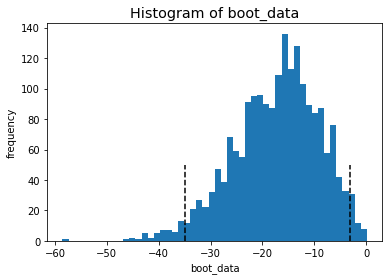

In [13]:
df_booted_mean = get_bootstrap(df_control.value, df_treatment.value, boot_it = 2000)

In [14]:
df_booted_mean["p_value"]

0.036011027410488936

**Манна-Уитни**

In [15]:
mannwhitneyu(df_control.value, df_treatment.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

**Бутстрап для медианы**

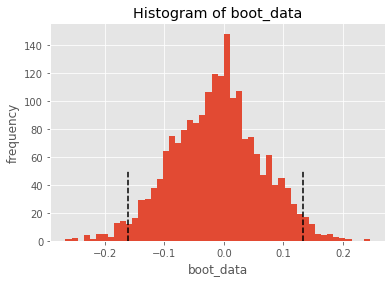

In [16]:
df_booted_median = get_bootstrap(df_control.value, df_treatment.value, boot_it = 2000, statistic = np.median)

In [17]:
df_booted_median["p_value"]

0.871833028524228

**Манна-Уитни**

In [18]:
mannwhitneyu(df_control.value, df_treatment.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Так как расчет средних очень чувствителен к выбросам - 
**проверим данные на выбросы**

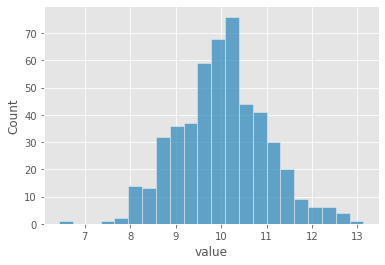

In [19]:
sns.histplot(data = df_control.value)

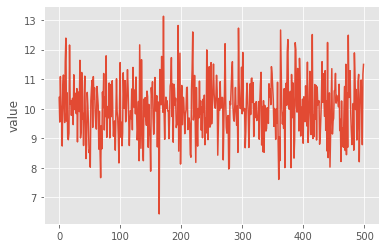

In [20]:
sns.lineplot(data = df_control.value)

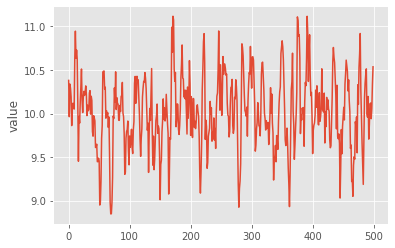

In [21]:
# Строим по скользящему среднему что бы сгладить шумы
df_control_rolling = df_control.value\
    .rolling(5, min_periods=1)\
    .mean()

sns.lineplot(data = df_control_rolling)

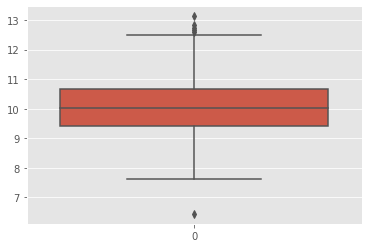

In [24]:
sns.boxplot(data = df_control.value)

**Выбросы detected**

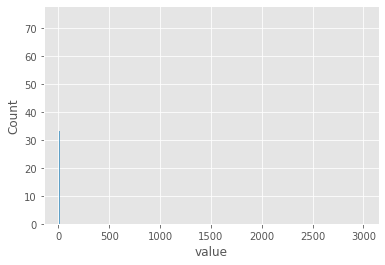

In [22]:
sns.histplot(data = df_treatment.value)

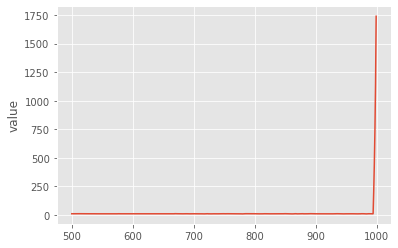

In [23]:
df_treatment_rolling = df_treatment.value\
    .rolling(5, min_periods=1)\
    .mean()

sns.lineplot(data = df_treatment_rolling)

Судя по boxplot, в контрольной группе **выбросы точно есть**

**Вывод:**
- Бутстрап показывает что различия в средних есть, критерий Манна-Уитни нет
- Бутсрап по медиане не показывают стат.значимого различия, как и критерий Манна-Уитни 

Опираясь на результаты двух тестов (Манна-Уитни и бутстрапа по медиане) можно сделать **вывод что различий нет, H0.** 

Различия в средних же судя по boxplot в конце ноутбука могут быть результатом выбросов.

# Ответ преподавателя


Верно следующее утверждение: Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки (иногда путают с равенством медиан, но на самом деле проверяется не только медиана). Также вы верно применили критерии и написали код


Про разное количество наблюдений в выборках: Манн-Уитни как и любой статистический оценщик не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект). Подробнее тут https://stats.stackexchange.com/questions/40342/mann-whitney-u-test-with-unequal-sample-sizes

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы

Хорошего дня!